In [1]:
# Necessary imports
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt 
import umap.plot as uplot
import umap.umap_ as umap
import hdbscan
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

c:\Users\nicho\anaconda3\envs\recSysEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Clustering
By clustering our data we minimized our search space for generating recommendations via dimension reduction, and explored possible groupings in our data on more complex featutes. Clustering was accomplished with UMAP and scikit-learn.

### Handling slight preprocessing
Before exploring clustering results we load in our data with BERT embeddings and apply scikit-learn vectorization methods.

In [2]:
# Loading in the data for tf-idf and bag of words vectorization methods.
news_text = pd.read_csv('../MIND_small/csv/news.csv').set_index('news_id').drop(columns=['Unnamed: 0','url','title_entities','abstract_entities'])
news_text = news_text[news_text['abstract'].isna() == False]
BERT_embeddings = pd.read_csv('../MIND_small/csv/news_BERT_extracted_embeddings.csv', index_col=0).drop(columns='Unnamed: 0')
BERT_embeddings.head()

,news_id,category,sub_category,0_title,1_title,2_title,3_title,4_title,5_title,6_title,...,758_abstract,759_abstract,760_abstract,761_abstract,762_abstract,763_abstract,764_abstract,765_abstract,766_abstract,767_abstract
0,N55528,lifestyle,lifestyleroyals,-0.760881,0.562061,0.999948,-0.994303,0.949045,0.764554,0.980931,...,0.677721,-0.131281,0.538551,-0.444421,-0.435791,-0.197555,-0.140542,0.999937,-0.683746,0.987187
1,N19639,health,weightloss,-0.787680,0.615142,0.999966,-0.993316,0.964220,0.723472,0.986800,...,0.711166,-0.305206,0.766647,-0.613100,-0.373641,-0.565517,-0.063743,0.999955,-0.884546,0.990700
2,N61837,news,newsworld,-0.622495,0.460947,0.999873,-0.990779,0.959267,0.900435,0.971245,...,0.480411,-0.497116,0.322929,-0.548832,-0.392572,-0.458578,-0.049935,0.999793,-0.713220,0.969965
3,N53526,health,voices,-0.740854,0.519224,0.999932,-0.995590,0.966713,0.854350,0.986236,...,0.703306,-0.143778,0.770481,-0.615078,-0.343000,-0.629248,0.026013,0.999943,-0.805562,0.988447
4,N38324,health,medical,-0.698660,0.462984,0.999867,-0.990970,0.960319,0.645505,0.976330,...,0.761685,-0.117997,0.125520,-0.445764,-0.291769,-0.475241,-0.179736,0.999929,-0.755804,0.974853


In [60]:
# Create sparse matrices of bag of words and tf-idf embeddings.
bag_vectorizer = CountVectorizer(stop_words='english')
tf_vectorizer = TfidfVectorizer(stop_words='english')
# bow_matrix = bag_vectorizer.fit_transform(news_text['abstract'] + news_text['title'])
# tf_matrix = tf_vectorizer.fit_transform(news_text['abstract'] + news_text['title'])
bow_matrix_ab = bag_vectorizer.fit_transform(news_text['abstract'])
tf_matrix_ab = tf_vectorizer.fit_transform(news_text['abstract'])
bow_matrix = bag_vectorizer.fit_transform(news_text['title'])
tf_matrix = tf_vectorizer.fit_transform(news_text['title'])
# If you would like to create a union umap might have to create separate matrices and then concaatenate them onto each other.

### Initial looks into embeddings for article Abstracts and Titles
To get a good idea of how embeddings might be grouped together for our different embedding methods, we include a small look into the 2 dimensional reductions via umap below.

In [57]:
BERT_umap = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(BERT_embeddings[BERT_embeddings.columns.to_list()[3:]])
bow_embeddings = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(bow_matrix)
tf_embeddings = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(tf_matrix)

c:\Users\nicho\anaconda3\envs\recSysEnv\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nicho\anaconda3\envs\recSysEnv\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nicho\anaconda3\envs\recSysEnv\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [61]:
BERT_umap = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(BERT_embeddings[BERT_embeddings.columns.to_list()[3:]])
bow_embeddings_ab = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(bow_matrix_ab)
tf_embeddings_ab = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(tf_matrix_ab)

c:\Users\nicho\anaconda3\envs\recSysEnv\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nicho\anaconda3\envs\recSysEnv\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nicho\anaconda3\envs\recSysEnv\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


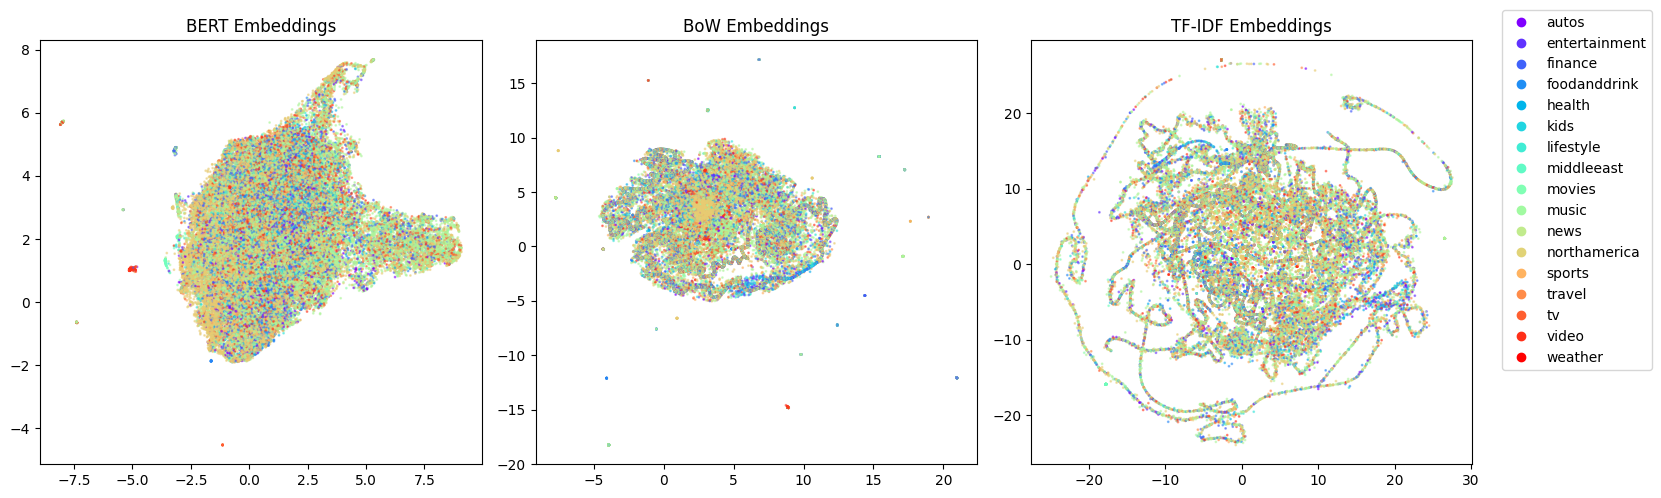

In [65]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import numpy as np
label = LabelEncoder()
categories = sorted(set(BERT_embeddings['category']))  # Update as necessary for your datasets
# Setup for the subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # Adjust the size as necessary
# cmap = plt.cm.get_cmap('rainbow', len(categories))
cmap = matplotlib.colormaps.get_cmap('rainbow')
category_to_id = {category: id for id, category in enumerate(categories)}

# BERT Embeddings
bert_categories_ids = [category_to_id[category] for category in BERT_embeddings['category']]
axs[0].scatter(BERT_umap[:, 0], BERT_umap[:, 1], c=[cmap(category_to_id[category]/len(categories)) for category in BERT_embeddings['category']], label=bert_categories_ids, alpha=0.5, s=1)
axs[0].set_title('BERT Embeddings')
# BoW Embeddings
bow_categories_ids = [category_to_id[category] for category in news_text['category']]
axs[1].scatter(bow_embeddings_ab[:, 0], bow_embeddings_ab[:, 1], c=[cmap(category_to_id[category]/len(categories)) for category in news_text['category']], label=bow_categories_ids, alpha=0.5, s=1)
axs[1].set_title('BoW Embeddings')

# TF Embeddings
tf_categories_ids = [category_to_id[category] for category in news_text['category']]
axs[2].scatter(tf_embeddings_ab[:, 0], tf_embeddings_ab[:, 1], c=[cmap(category_to_id[category]/len(categories)) for category in news_text['category']], label=tf_categories_ids, alpha=0.5, s=1)
axs[2].set_title('TF-IDF Embeddings')
# # BoW Embeddings
# bow_categories_ids = [category_to_id[category] for category in news_text['category']]
# axs[1].scatter(bow_embeddings[:, 0], bow_embeddings[:, 1], c=[cmap(category_to_id[category]/len(categories)) for category in news_text['category']], label=bow_categories_ids, alpha=0.5, s=1)
# axs[1].set_title('BoW Embeddings')

# # TF Embeddings
# tf_categories_ids = [category_to_id[category] for category in news_text['category']]
# axs[2].scatter(tf_embeddings[:, 0], tf_embeddings[:, 1], c=[cmap(category_to_id[category]/len(categories)) for category in news_text['category']], label=tf_categories_ids, alpha=0.5, s=1)
# axs[2].set_title('TF-IDF Embeddings')

# Generate colors from the colormap for the legend
category_values = np.linspace(0, 1, len(categories))
colors = [cmap(value) for value in category_values]

# Create a legend
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', label=category)
                  for category, color in zip(categories, colors)]

# Add a figure-wide legend outside the right side of the subplots
fig.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
plt.tight_layout()

# Show plot
plt.show()

By clustering we can see that text vectorized by tf-idf has a much wider spread and more clearly defined clusters after being pushed into two dimensions. Due to this structure we utilize tf-idf embeddings for clustering.

### Creating a user-item matrix
With reduced dimension embeddings created we can then move on to creating the user item matrix

In [ ]:
def tune_clustering(matrix, n_components=50, metric='euclidean', min_cluster_size=500, n_neighbors=30):
    umap_embeddings = umap.UMAP(
        n_neighbors=30,
        min_dist=0.0,
        n_components=n_components,
        random_state=42,
        metric=metric
    ).fit_transform(matrix)
    hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(umap_embeddings)
    clustered = (hdbscan_labels >= 0)
    print(f"CLUSTERED: Adjusted random score is: {adjusted_rand_score(news_text['category'][clustered], hdbscan_labels[clustered])},\n Adjusted mutual info is: {adjusted_mutual_info_score(news_text['category'][clustered], hdbscan_labels[clustered])}")
    print(f"Adjusted random score is: {adjusted_rand_score(news_text['category'], hdbscan_labels)},\n Adjusted mutual info is: {adjusted_mutual_info_score(news_text['category'], hdbscan_labels)}")    

In [ ]:
def tune_clustering(matrix, labels, mat_name, n_components=50, metric='euclidean', min_cluster_size=500, n_neighbors=30, min_dist=0.0, min_samples=5, random_state=42, counter=0):
    """
    Tune clustering parameters and evaluate clustering performance.

    Parameters:
    - matrix: Data matrix to cluster.
    - labels: True labels for evaluation.
    - n_components: Number of dimensions for UMAP.
    - metric: Distance metric for UMAP.
    - min_cluster_size: Minimum cluster size for HDBSCAN.
    - n_neighbors: Number of neighbors for UMAP.
    - min_dist: Minimum distance between points in UMAP space.
    - min_samples: Minimum samples for HDBSCAN.
    - random_state: Random state for reproducibility.

    Returns:
    - Prints evaluation scores.
    """
    try:
        umap_embeddings = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            random_state=random_state,
            metric=metric,
        ).fit_transform(matrix)
        
        hdbscan_labels = hdbscan.HDBSCAN(
            min_samples=min_samples,
            min_cluster_size=min_cluster_size
        ).fit_predict(umap_embeddings)
        
        clustered = (hdbscan_labels >= 0)
        if clustered.any():
            data = pd.DataFrame(data = {'mat' : mat_name, 'n_neighbors' : n_neighbors, 'min_dist' : min_dist, 'n_components' : n_components, 'metric' : metric, 'min_samples' : min_samples, 'min_dist' : min_dist,
                                    'clustered_rand' : adjusted_rand_score(labels[clustered], hdbscan_labels[clustered]),
                                    'clustered_info' : adjusted_mutual_info_score(labels[clustered], hdbscan_labels[clustered]),
                                    'overall_rand' : adjusted_rand_score(labels, hdbscan_labels),
                                    'overall_info' : adjusted_mutual_info_score(labels, hdbscan_labels)})

            data.to_csv('cluster_tuning.csv', mode='a', index = [counter])

        else:
            print("No clusters formed with the given parameters.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
n_components_range = [10, 50, 100]
min_cluster_size_range = [100, 500, 1000]
n_neighbors_range = [10, 30, 50]
min_dist_range = [0.0, 0.1, 0.5]
min_samples_range = [5, 10, 20]

# Iterate over each parameter range
counter = 0
for n_components in n_components_range:
    for min_cluster_size in min_cluster_size_range:
        for n_neighbors in n_neighbors_range:
            for min_dist in min_dist_range:
                for min_samples in min_samples_range:
                    print(f"Testing parameters: n_components={n_components}, min_cluster_size={min_cluster_size}, "
                          f"n_neighbors={n_neighbors}, min_dist={min_dist}, min_samples={min_samples}")
                    
                    tune_clustering(tf_matrix, news_text['category'],
                                    'tfidf',
                                    n_components=n_components, 
                                    metric='euclidean', 
                                    min_cluster_size=min_cluster_size, 
                                    n_neighbors=n_neighbors, 
                                    min_dist=min_dist, 
                                    min_samples=min_samples,
                                    counter=counter, 
                                    random_state=42)
                    counter += 1
                     


In [ ]:
components = [5, 25, 50]
for component in components:
    tune_clustering(tf_matrix, n_components=component)

In [ ]:
umap_embeddings_norm = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=50,
    random_state=42
).fit_transform(tf_normalized)

In [ ]:
umap_embeddings = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=50,
    random_state=42
).fit_transform(tf_matrix)

In [ ]:
umap_embeddings_dim_2 = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(tf_matrix)

In [ ]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(umap_embeddings)

In [ ]:
hdbscan_labels_norm = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(umap_embeddings_norm)

In [ ]:
hdbscan_labels_dim_2 = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(umap_embeddings_dim_2)

In [ ]:
clustered = (hdbscan_labels_dim_2 >= 0)
plt.scatter(umap_embeddings_dim_2[~clustered, 0],
            umap_embeddings_dim_2[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embeddings_dim_2[clustered, 0],
            umap_embeddings_dim_2[clustered, 1],
            c=hdbscan_labels_dim_2[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
len(hdbscan_labels)

In [ ]:
len(hdbscan_labels_dim_2)

In [ ]:
clustered = (hdbscan_labels_norm >= 0)
print(
    adjusted_rand_score(news_text['category'][clustered], hdbscan_labels_norm[clustered]),
    adjusted_mutual_info_score(news_text['category'][clustered], hdbscan_labels_norm[clustered])
)

In [ ]:
print(adjusted_rand_score(news_text['category'], hdbscan_labels_norm), adjusted_mutual_info_score(news_text['category'], hdbscan_labels_norm))

In [ ]:
clustered = (hdbscan_labels >= 0)
print(
    adjusted_rand_score(news_text['category'][clustered], hdbscan_labels[clustered]),
    adjusted_mutual_info_score(news_text['category'][clustered], hdbscan_labels[clustered])
)

In [ ]:
print(adjusted_rand_score(news_text['category'], hdbscan_labels), adjusted_mutual_info_score(news_text['category'], hdbscan_labels))

In [ ]:
clustered = (hdbscan_labels >= 0)
plt.scatter(umap_embeddings[~clustered, 0],
            umap_embeddings[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embeddings[clustered, 0],
            umap_embeddings[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
## Now moving onto exploring the embeddings generated by BERT and how they might work
embeddings=pd.read_csv('pure_embeddings.csv').set_index('news_id')
news = pd.read_csv('MIND_small/csv/news_big_embeddings.csv').drop(columns=['Unnamed: 0', 'abstract_entities', 'title_entities', 'url'])
news = news[news['abstract_embeddings'] != '[0]']
news = news[news['abstract_embeddings'].isna() == False].set_index('news_id')
news.drop(columns = ['abstract_embeddings', 'title_embeddings'], inplace=True)
bert_df = pd.concat([news, embeddings], axis=1).drop(columns=['Unnamed: 0.1', 'title', 'abstract'])

In [ ]:
bert_umap_embeddings = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=50,
    random_state=42).fit(bert_df[bert_df.columns.to_list()[2:]])

In [ ]:
uplot.points(bert_umap_embeddings, labels=bert_df['category'], cmap='vtidis')